In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 뉴스 기사 분류: 다중 분류 문제

두 개 이상의 클래스가 있을 때는 어떻게 해야 할까?

로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망 만들기. 클래스가 많기 때문에 이 문제는 다중 분류다. 각 데이터 포인트가 정확히 하나의 범주로 분류되기 때문에 좀 더 정확히 말하면 단일 레이블 다중 분류 문제이다. 각 데이터 포인트가 여러 개의 범주(가령, 토픽)에 속할 수 있다면 이런 문제는 다중 레이블 다중 분류의 문제가 된다.


# 로이터 데이터셋 
1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용. 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋이다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있습니다.


In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


매개변수는 데이터에서 가장 자주 등장하는 단어 10,000개로 제한.

train : 8,982개 test : 2,246개

In [5]:
len(train_data)


8982

In [6]:
len(test_data)

2246

In [7]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [8]:
#단어 디코딩 법


word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 1us/step


In [9]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수

In [10]:
train_labels[10]

3

# 데이터 준비
데이터를 벡터로 변환하기

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸는 방법은 2가지가 있다.

>방법1 : 레이블의 리스트를 정수 텐서로 변환하는 것

>방법2 :  원-핫 인코딩을 사용하는 것. 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩이라고도 부른다. 이 경우 레이블의 원-핫 인코딩은 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터다

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 훈련 레이블 벡터 변환
one_hot_train_labels = to_one_hot(train_labels)
# 테스트 레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels)

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

# 모델 구성
이 토픽 분류 문제는 이전의 영화 리뷰 분류 문제와 비슷해 보이나 여기에서는 출력 클래스의 개수가 2에서 46개로 늘어난 점입니다. 출력 공간의 차원이 훨씬 커졌다.

이전에 사용했던 것처럼 Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없다. 각 층은 잠재적으로 정보의 병목이 될 수 있다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 *16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 것 같다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있다.*

이런 이유로 좀 더 규모가 큰 층을 사용하자. 64개의 유닛을 사용:

In [15]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


이 구조에서 주목할 점:

마지막 Dense 층의 크기가 46이다. 각 입력 샘플에 대해서 46차원의 벡터를 출력한다는 뜻. 이 벡터의 각 원소(각 차원)은 각기 다른 출력 클래스가 인코딩된 것이고 마지막 층에 softmax 활성화 함수가 사용되었다. (MNIST 예제에서 이런 방식을 봤다. )각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력한다. 즉, 46차원의 출력 벡터를 만들며 output[i]는 어떤 샘플이 클래스 i에 속할 확률이다. 46개의 값을 모두 더하면 1이 된다.
이런 문제에 사용할 **최선의 손실 함수는 categorical_crossentropy**이다. 이 함수는 두 확률 분포의 사이의 거리를 측정한다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리이다*. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 된다.*

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 훈련 검증
훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

20번의 에포크로 모델 훈련하기

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 184us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 154us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 151us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 150us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.7033 - acc: 0.8470 - val_loss: 0.9843 - val_acc: 0.7820
Epoch 6/20
7982/7982 [==============================] - 1s 152us/step - loss: 0.5665 - acc: 0.8797 - val_loss: 0.9412 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 151us/step - loss: 0.4579 - a

In [0]:
import matplotlib.pyplot as plt

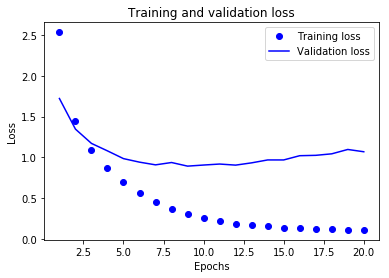

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

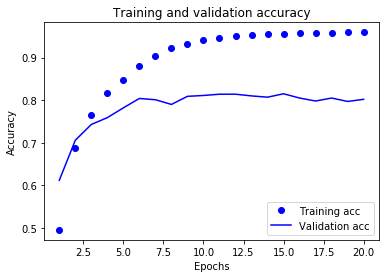

In [21]:
plt.clf()   # 그래프를 초기화합니다

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 9번째 에포크 이후에 과대적합이 시작됨. 9번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가하자

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 193us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 153us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 154us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 154us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 154us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 155us/step - loss: 0.5124 - acc: 0.8923 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 153us/step - loss: 0.4123 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [23]:
results

[1.022207990036622, 0.7756010686194165]

대략 78%의 정확도를 보인다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성한다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 19% 정도를 달성한다. 여기에 비하면  꽤 좋은 결과이다.

In [24]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.182546749777382

# 새로운 데이터에 대해 예측하기
모델 인스턴스의 predict 메서드는 46개 토픽에 대한 확률 분포를 반환한다. 테스트 데이터 전체에 대한 토픽을 예측하자

In [0]:
predictions = model.predict(x_test)

predictions의 각 항목은 길이가 46인 벡터

In [26]:
predictions[0].shape

(46,)

벡터의 원소 합은 1이다.

In [27]:
np.sum(predictions[0])

1.0

# 레이블과 손실을 다루는 다른 방법
앞서 언급한 것처럼 레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것이다:

In [0]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

이 방식을 사용하려면 손실 함수 하나만 바꾸면 돤다.



In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

이 손실 함수는 인터페이스만 다를 뿐이고 수학적으로는 categorical_crossentropy와 동일함.

충분히 큰 중간층을 두어야 하는 이유
앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 된다. 46차원보다 훨씬 작은 중간층(예를 들면 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해야 한다.

In [30]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 333us/step - loss: 2.6581 - acc: 0.3776 - val_loss: 1.9677 - val_acc: 0.5350
Epoch 2/20
7982/7982 [==============================] - 2s 258us/step - loss: 1.6663 - acc: 0.6218 - val_loss: 1.5409 - val_acc: 0.6230
Epoch 3/20
7982/7982 [==============================] - 2s 258us/step - loss: 1.3346 - acc: 0.6680 - val_loss: 1.3945 - val_acc: 0.6790
Epoch 4/20
7982/7982 [==============================] - 2s 260us/step - loss: 1.1438 - acc: 0.7265 - val_loss: 1.3224 - val_acc: 0.6940
Epoch 5/20
7982/7982 [==============================] - 2s 258us/step - loss: 1.0121 - acc: 0.7453 - val_loss: 1.2708 - val_acc: 0.7030
Epoch 6/20
7982/7982 [==============================] - 2s 262us/step - loss: 0.9106 - acc: 0.7578 - val_loss: 1.2768 - val_acc: 0.7090
Epoch 7/20
7982/7982 [==============================] - 2s 259us/step - loss: 0.8308 - acc: 0.7735 - val_loss: 1.2572 - val_acc: 0.7110


검증 정확도의 최고 값은 약 71%로 8% 정도 감소했다. 이런 손실의 대부분 원인은 많은 정보(46개 클래스의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문이다. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부는 넣지 못했다.



---
4월 28일 이후


# 추가 실험
더 크거나 작은 층을 사용해 보세요: 32개 유닛, 128개 유닛 등
여기에서 두 개의 은닉층을 사용했습니다. 한 개의 은닉층이나 세 개의 은닉층을 사용해 보세요.


# 정리

* N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 Dense 층의 크기는 N이어야 한다.
* 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 softmax 활성화 함수를 사용해야 한다.
* 이런 문제에는 항상 범주형 크로스엔트로피를 사용해야 한다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화한다.
* 다중 분류에서 레이블을 다루는 두 가지 방법이 있다.
>* 레이블을 범주형 인코딩(또는 원-핫 인코딩)으로 인코딩하고 categorical_crossentropy 손실 함수를 사용한다.
>* 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy 손실 함수를 사용한다.
* 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 한다.